<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-11 17:24:33.830662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 17:24:36.151181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-11 17:24:36.152487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-11 17:24:36.153524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-11 17:24:39,036[INFO][139954536056640-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

# generate datasets
train_size= 40 #@param {type:"integer"}
test_size = 2  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_source = '/cic/dataset/normalized_labeled/nsm-huongftp-v3-label/' #@param {type:"string"}
L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()'])
predict_size = total_size // n_timesteps_in
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-02-11 17:24:41,256	WARNING read_api.py:256 -- The number of blocks in this dataset (17) limits its parallelism to 17 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_count

label  count()
0    0.0     1489
1    1.0      147

## Data preview

### L_train preview

In [5]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0       0.0           0.0         0.0          0.0         0.0         0.0   
1       0.0           0.0         0.0          0.0         0.0         0.0   
2       0.0           0.0         0.0          0.0         0.0         0.0   
3       0.0           0.0         0.0          0.0         0.0         0.0   
4       0.0           0.0         0.0          0.0         0.0         0.0   
...     ...           ...         ...          ...         ...         ...   
1595    0.0           0.0         0.0          0.0         0.0         0.0   
1596    0.0           0.0         0.0          0.0         0.0         0.0   
1597    0.0           0.0         0.0          0.0         0.0         0.0   
1598    0.0           0.0         0.0          0.0         0.0         0.0   
1599    0.0           0.0         0.0          0.0         0.0         0.0   

      bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                  0.0             0.0             1.0          0.0   
1                  0.0             0.0             1.0          0.0   
2                  0.0             0.0             1.0          0.0   
3                  0.0             0.0             0.0          0.0   
4                  0.0             0.0             1.0          1.0   
...                ...             ...             ...          ...   
1595               0.0             0.0             0.0          0.0   
1596               0.0             0.0             0.0          0.0   
1597               0.0             0.0             0.0          0.0   
1598               0.0             0.0             1.0          0.0   
1599               0.0             0.0             0.0          0.0   

      bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0              0.0          0.0          0.0          0.0              1.0   
1              0.0          0.0          0.0          0.0              1.0   
2              0.0          0.0          0.0          0.0              1.0   
3              0.0          0.0          0.0          0.0              0.0   
4              1.0          1.0          1.0          1.0              1.0   
...            ...          ...          ...          ...              ...   
1595           0.0          0.0          0.0          0.0              0.0   
1596           0.0          0.0          0.0          0.0              0.0   
1597           0.0          0.0          0.0          0.0              0.0   
1598           0.0          0.0          0.0          0.0              1.0   
1599           0.0          0.0          0.0          0.0              0.0   

      bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                  1.0              1.0              1.0             0.0   
1                  1.0              1.0              1.0             0.0   
2                  1.0              1.0              1.0             0.0   
3                  0.0              0.0              0.0             0.0   
4                  1.0              1.0              0.0             0.0   
...                ...              ...              ...             ...   
1595               0.0              0.0              0.0             0.0   
1596               0.0              0.0              0.0             0.0   
1597               0.0              0.0              0.0             0.0   
1598               1.0              1.0              1.0             0.0   
1599               0.0              0.0              0.0             0.0   

      bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0            1.0            0.0               1.0            0.0   
1            1.0            0.0               1.0            0.0   
2            1.0            0.0               1.0            0.0   
3            0.0            0.0               0.0            0.0   
4            1.0          

In [6]:
L_predict[[LABEL, *features]].describe()

label  ack_flag_cnt   active_max  active_mean   active_min  \
count  1600.000000        1600.0  1600.000000  1600.000000  1600.000000   
mean      0.091875           0.0     0.123125     0.123125     0.123125   
std       0.288940           0.0     0.328683     0.328683     0.328682   
min       0.000000           0.0     0.000000     0.000000     0.000000   
25%       0.000000           0.0     0.000000     0.000000     0.000000   
50%       0.000000           0.0     0.000000     0.000000     0.000000   
75%       0.000000           0.0     0.000000     0.000000     0.000000   
max       1.000000           0.0     1.000000     1.000000     1.000000   

        active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  1600.000000       1600.000000     1600.000000      1600.00000   
mean      0.123125          0.044375        0.044375         0.60375   
std       0.328683          0.205991        0.205991         0.48927   
min       0.000000          0.000000        0.000000         0.00000   
25%       0.000000          0.000000        0.000000         0.00000   
50%       0.000000          0.000000        0.000000         1.00000   
75%       0.000000          0.000000        0.000000         1.00000   
max       1.000000          1.000000        1.000000         1.00000   

       bwd_iat_max  bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  \
count  1600.000000   1600.000000  1600.000000  1600.000000  1600.000000   
mean      0.296250      0.296250     0.267227     0.296250     0.296250   
std       0.456745      0.456745     0.464453     0.456745     0.456745   
min       0.000000      0.000000    -1.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       1.000000      1.000000     0.999909     1.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count       1600.00000        1600.00000       1600.00000      1600.000000   
mean           0.60375           0.60375          0.60375         0.292617   
std            0.48927           0.48927          0.48927         0.449581   
min            0.00000           0.00000          0.00000         0.000000   
25%            0.00000           0.00000          0.00000         0.000000   
50%            1.00000           1.00000          1.00000         0.000000   
75%            1.00000           1.00000          1.00000         0.969503   
max            1.00000           1.00000          1.00000         1.000000   

       bwd_pkts_b_avg   bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count     1600.000000  1600.000000         1600.0        1600.00000   
mean         0.044355     0.569888            0.0           0.60375   
std          0.205896     0.481243            0.0           0.48927   
min          0.000000     0.000000            0.0           0.00000   
25%          0.000000     0.000000            0.0           0.00000   
50%          0.000000     0.999092            0.0           1.00000   
75%          0.000000     1.000000            0.0           1.00000   
max          1.000000     1.000000            0.0           1.00000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count         1600.0          1600.0    1600.000000    1600.0        1600.0   
mean             0.0             0.0       0.428397       1.0           0.0   
std              0.0             0.0       0.375588       0.0           0.0   
min              0.0             0.0       0.000000       1.0           0.0   
25%              0.0             0.0       0.000000       1.0           0.0   
50%              0.0             0.0       0.463266       1.0           0.0   
75%              0.0             0.0       0.761594       1.0           0.0   
max              0.0             0.0 

In [7]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9         10   11   12   13  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  1.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  1.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  1.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  1.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  1.0   
97  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0 -1.000000  1.0  1.0  1.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.999988  1.0  1.0  1.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   

     14   15   16   17        18   19   20   21   22        23   24   25  \
0   1.0  1.0  1.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
1   1.0  1.0  1.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
2   1.0  1.0  1.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
3   0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
4   1.0  1.0  0.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
..  ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  ...  ...   
95  1.0  1.0  0.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.964028  1.0  0.0   
96  1.0  1.0  0.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.964028  1.0  0.0   
97  1.0  1.0  1.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.705901  1.0  0.0   
98  1.0  1.0  1.0  0.0  0.963577  0.0  1.0  0.0  0.0  0.964028  1.0  0.0   
99  1.0  1.0  0.0  0.0  0.964073  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   

          26   27   28   29   30        31   32        33        34   35   36  \
0   0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.000000  0.761594  0.0  0.0   
1   0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.000000  0.761594  0.0  0.0   
2   0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.000000  0.761594  0.0  0.0   
3   0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.778453  1.000000  0.0  0.0   
4   0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.000000  0.964028  0.0  0.0   
..       ...  ...  ...  ...  ...       ...  ...       ...       ...  ...  ...   
95  0.761594  1.0  1.0  1.0  1.0  0.999329  1.0  1.000000  0.000000  0.0  0.0   
96  0.761594  1.0  1.0  1.0  1.0  0.999329  1.0  1.000000  0.000000  0.0  0.0   
97  0.761594  1.0  1.0  1.0  1.0 -1.000000  1.0  1.000000  1.000000  1.0  1.0   
98  0.761594  1.0  1.0  1.0  1.0  0.999988  1.0  0.994960  0.761594  0.0  0.0   
99  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.999331  1.000000  0.0  0.0   

     37   38   39   40   41   42   43   44   45   46        47        48   49  \
0   1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.000000  1.000000  0.0   
1   1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.000000  1.000000  0.0   
2   1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.000000  1.000000  0.0   
3   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.778453  0.0   
4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  1.000000  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...   
95  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.000000  1.000000  0.0   
96  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.000000  1.000000  0.0   
97  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.999906  1.000000  0.0   
98  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.760259  0.0   
99  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.964073  0.0   

     50   51   52   53   54   55   56   57   58   59   60   61   62   63   64  \
0   1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1   1.0  1.

In [8]:
DataFrame.from_records(LX_predict[0]).describe()

0       1       2       3       4      5      6       7   \
count  100.0  100.00  100.00  100.00  100.00  100.0  100.0  100.00   
mean     0.0    0.01    0.01    0.01    0.01    0.0    0.0    0.99   
std      0.0    0.10    0.10    0.10    0.10    0.0    0.0    0.10   
min      0.0    0.00    0.00    0.00    0.00    0.0    0.0    0.00   
25%      0.0    0.00    0.00    0.00    0.00    0.0    0.0    1.00   
50%      0.0    0.00    0.00    0.00    0.00    0.0    0.0    1.00   
75%      0.0    0.00    0.00    0.00    0.00    0.0    0.0    1.00   
max      0.0    1.00    1.00    1.00    1.00    0.0    0.0    1.00   

               8           9           10          11          12      13  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.00   
mean     0.040000    0.040000    0.020000    0.040000    0.040000    0.99   
std      0.196946    0.196946    0.199999    0.196946    0.196946    0.10   
min      0.000000    0.000000   -1.000000    0.000000    0.000000    0.00   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    1.00   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    1.00   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    1.00   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.00   

           14      15          16     17          18     19      20     21  \
count  100.00  100.00  100.000000  100.0  100.000000  100.0  100.00  100.0   
mean     0.99    0.99    0.050000    0.0    0.989276    0.0    0.99    0.0   
std      0.10    0.10    0.219043    0.0    0.100056    0.0    0.10    0.0   
min      0.00    0.00    0.000000    0.0    0.000000    0.0    0.00    0.0   
25%      1.00    1.00    0.000000    0.0    1.000000    0.0    1.00    0.0   
50%      1.00    1.00    0.000000    0.0    1.000000    0.0    1.00    0.0   
75%      1.00    1.00    0.000000    0.0    1.000000    0.0    1.00    0.0   
max      1.00    1.00    1.000000    0.0    1.000000    0.0    1.00    0.0   

          22          23     24     25            26     27     28      29  \
count  100.0  100.000000  100.0  100.0  1.000000e+02  100.0  100.0  100.00   
mean     0.0    0.937636    1.0    0.0  7.615942e-01    1.0    1.0    0.99   
std      0.0    0.110699    0.0    0.0  2.231632e-16    0.0    0.0    0.10   
min      0.0    0.000000    1.0    0.0  7.615942e-01    1.0    1.0    0.00   
25%      0.0    0.964028    1.0    0.0  7.615942e-01    1.0    1.0    1.00   
50%      0.0    0.964028    1.0    0.0  7.615942e-01    1.0    1.0    1.00   
75%      0.0    0.964028    1.0    0.0  7.615942e-01    1.0    1.0    1.00   
max      0.0    0.964028    1.0    0.0  7.615942e-01    1.0    1.0    1.00   

           30          31          32          33          34      35      36  \
count  100.00  100.000000  100.000000  100.000000  100.000000  100.00  100.00   
mean     0.99    0.969821    0.989999    0.997727    0.085336    0.01    0.01   
std      0.10    0.222679    0.100000    0.022155    0.259784    0.10    0.10   
min      0.00   -1.000000    0.000000    0.778453    0.000000    0.00    0.00   
25%      1.00    0.999998    1.000000    1.000000    0.000000    0.00    0.00   
50%      1.00    1.000000    1.000000    1.000000    0.000000    0.00    0.00   
75%      1.00    1.000000    1.000000    1.000000    0.000000    0.00    0.00   
max      1.00    1.000000    1.000000    1.000000    1.000000    1.00    1.00   

          37          38          39          40          41          42  \
count  100.0  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.0    0.050000    0.050000    0.050000    0.050000    0.050000   
std      0.0    0.219043    0.219043    0.219043    0.219043    0.219043   
min      1.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.0    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.0    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.0    0

In [9]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     45   46   47   48   49   50   51   52   53   54   55   56   57   58   59  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     60   61   62   63   64   65   66   67   68   69   70   71   72   73   74  \
0   0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
DataFrame.from_records(Ly_predict).describe()

0     1     2        3        4        5     6     7     8     9   \
count  16.0000  16.0  16.0  16.0000  16.0000  16.0000  16.0  16.0  16.0  16.0   
mean    0.0625   0.0   0.0   0.0625   0.0625   0.0625   0.0   0.0   0.0   0.0   
std     0.2500   0.0   0.0   0.2500   0.2500   0.2500   0.0   0.0   0.0   0.0   
min     0.0000   0.0   0.0   0.0000   0.0000   0.0000   0.0   0.0   0.0   0.0   
25%     0.0000   0.0   0.0   0.0000   0.0000   0.0000   0.0   0.0   0.0   0.0   
50%     0.0000   0.0   0.0   0.0000   0.0000   0.0000   0.0   0.0   0.0   0.0   
75%     0.0000   0.0   0.0   0.0000   0.0000   0.0000   0.0   0.0   0.0   0.0   
max     1.0000   0.0   0.0   1.0000   1.0000   1.0000   0.0   0.0   0.0   0.0   

         10    11       12       13       14       15       16       17  \
count  16.0  16.0  16.0000  16.0000  16.0000  16.0000  16.0000  16.0000   
mean    0.0   0.0   0.0625   0.0625   0.0625   0.0625   0.0625   0.0625   
std     0.0   0.0   0.2500   0.2500   0.2500   0.2500   0.2500   0.2500   
min     0.0   0.0   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
25%     0.0   0.0   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
50%     0.0   0.0   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
75%     0.0   0.0   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
max     0.0   0.0   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   

            18       19       20         21         22         23         24  \
count  16.0000  16.0000  16.0000  16.000000  16.000000  16.000000  16.000000   
mean    0.0625   0.0625   0.0625   0.125000   0.125000   0.125000   0.125000   
std     0.2500   0.2500   0.2500   0.341565   0.341565   0.341565   0.341565   
min     0.0000   0.0000   0.0000   0.000000   0.000000   0.000000   0.000000   
25%     0.0000   0.0000   0.0000   0.000000   0.000000   0.000000   0.000000   
50%     0.0000   0.0000   0.0000   0.000000   0.000000   0.000000   0.000000   
75%     0.0000   0.0000   0.0000   0.000000   0.000000   0.000000   0.000000   
max     1.0000   1.0000   1.0000   1.000000   1.000000   1.000000   1.000000   

            25       26       27       28       29         30         31  \
count  16.0000  16.0000  16.0000  16.0000  16.0000  16.000000  16.000000   
mean    0.0625   0.0625   0.0625   0.0625   0.0625   0.125000   0.125000   
std     0.2500   0.2500   0.2500   0.2500   0.2500   0.341565   0.341565   
min     0.0000   0.0000   0.0000   0.0000   0.0000   0.000000   0.000000   
25%     0.0000   0.0000   0.0000   0.0000   0.0000   0.000000   0.000000   
50%     0.0000   0.0000   0.0000   0.0000   0.0000   0.000000   0.000000   
75%     0.0000   0.0000   0.0000   0.0000   0.0000   0.000000   0.000000   
max     1.0000   1.0000   1.0000   1.0000   1.0000   1.000000   1.000000   

              32         33         34         35         36         37  \
count  16.000000  16.000000  16.000000  16.000000  16.000000  16.000000   
mean    0.125000   0.125000   0.125000   0.125000   0.125000   0.125000   
std     0.341565   0.341565   0.341565   0.341565   0.341565   0.341565   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              38         39         40         41         42         43  \
count  16.000000  16.000000  16.000000  16.000000  16.000000  16.000000   
mean    0.125000   0.125000   0.125000   0.125000   0.125000   0.125000   
std     0.341565   0.341565   0.341565   0.341565   0.341565   0.341565   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

## Data visualization

In [11]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

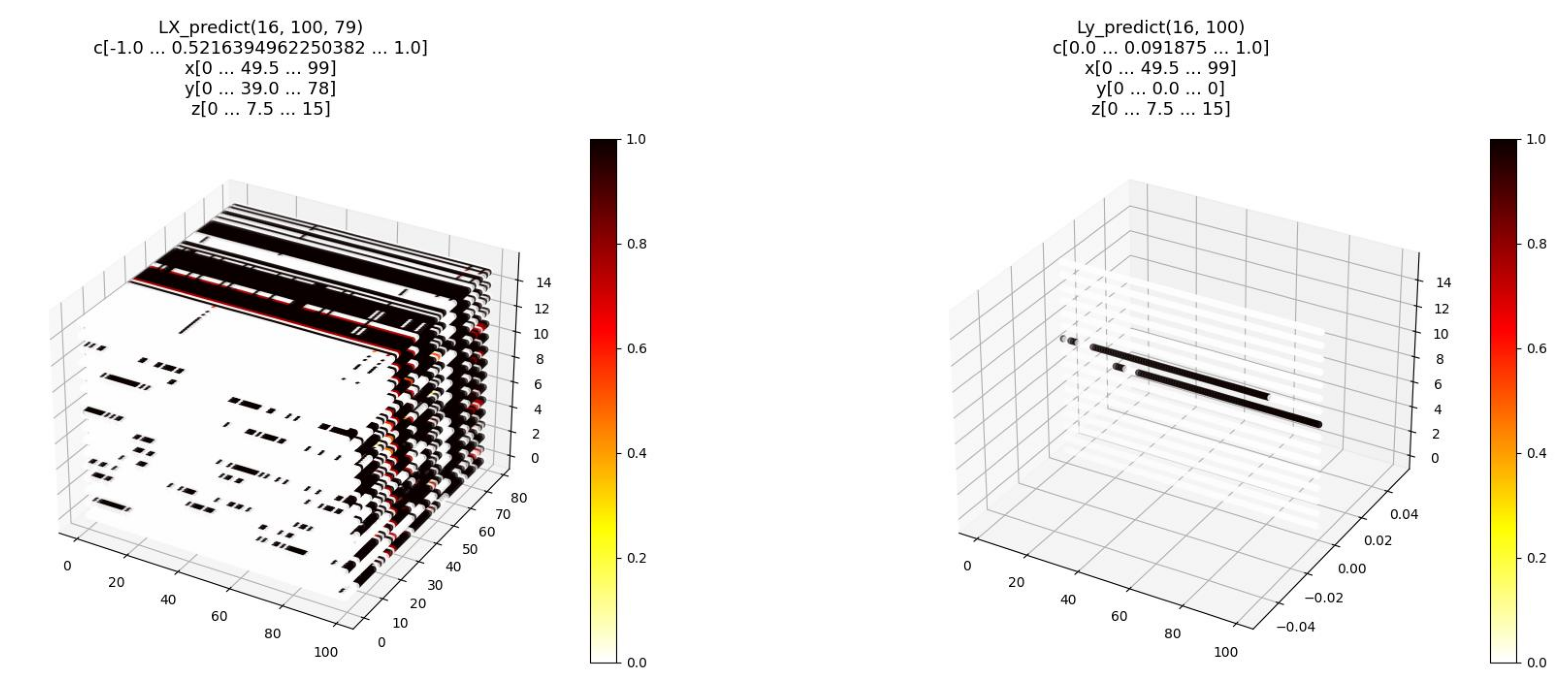

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [13]:
def threshold(num):
    return 1 if num > 0.5 else 0

def infer(name='model', checkpoint='anomaly_flow79_local_ftp_norm'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    print(f"predicted/Ly_predict = {predicted.sum()}/{Ly_predict.sum()}")
    #np.logical_and(predicted.reshape((56,100)), Ly_predict).sum()

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-02-11 17:24:51.344347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-11 17:24:51.345167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-11 17:24:51.345927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-11 17:24:51.346681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


predicted/Ly_predict = 144/147.0


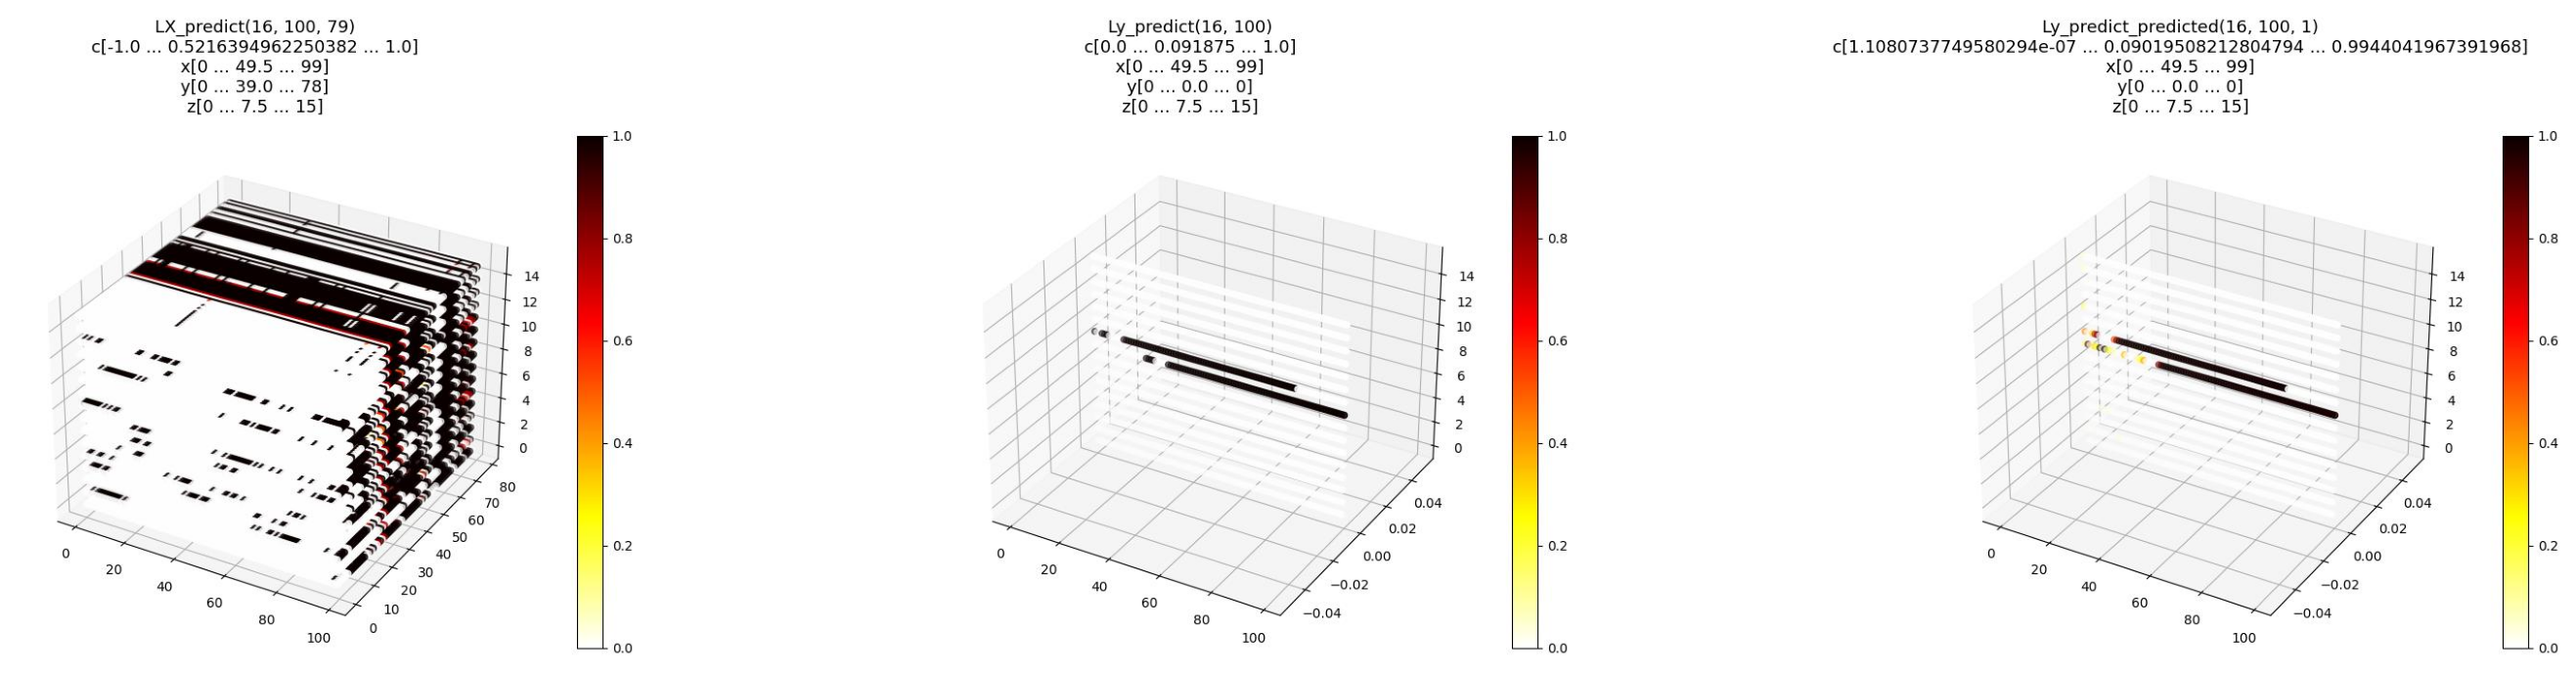

In [14]:
infer('model6', 'anomaly_flow79_local_ftp_norm')

predicted/Ly_predict = 491/147.0


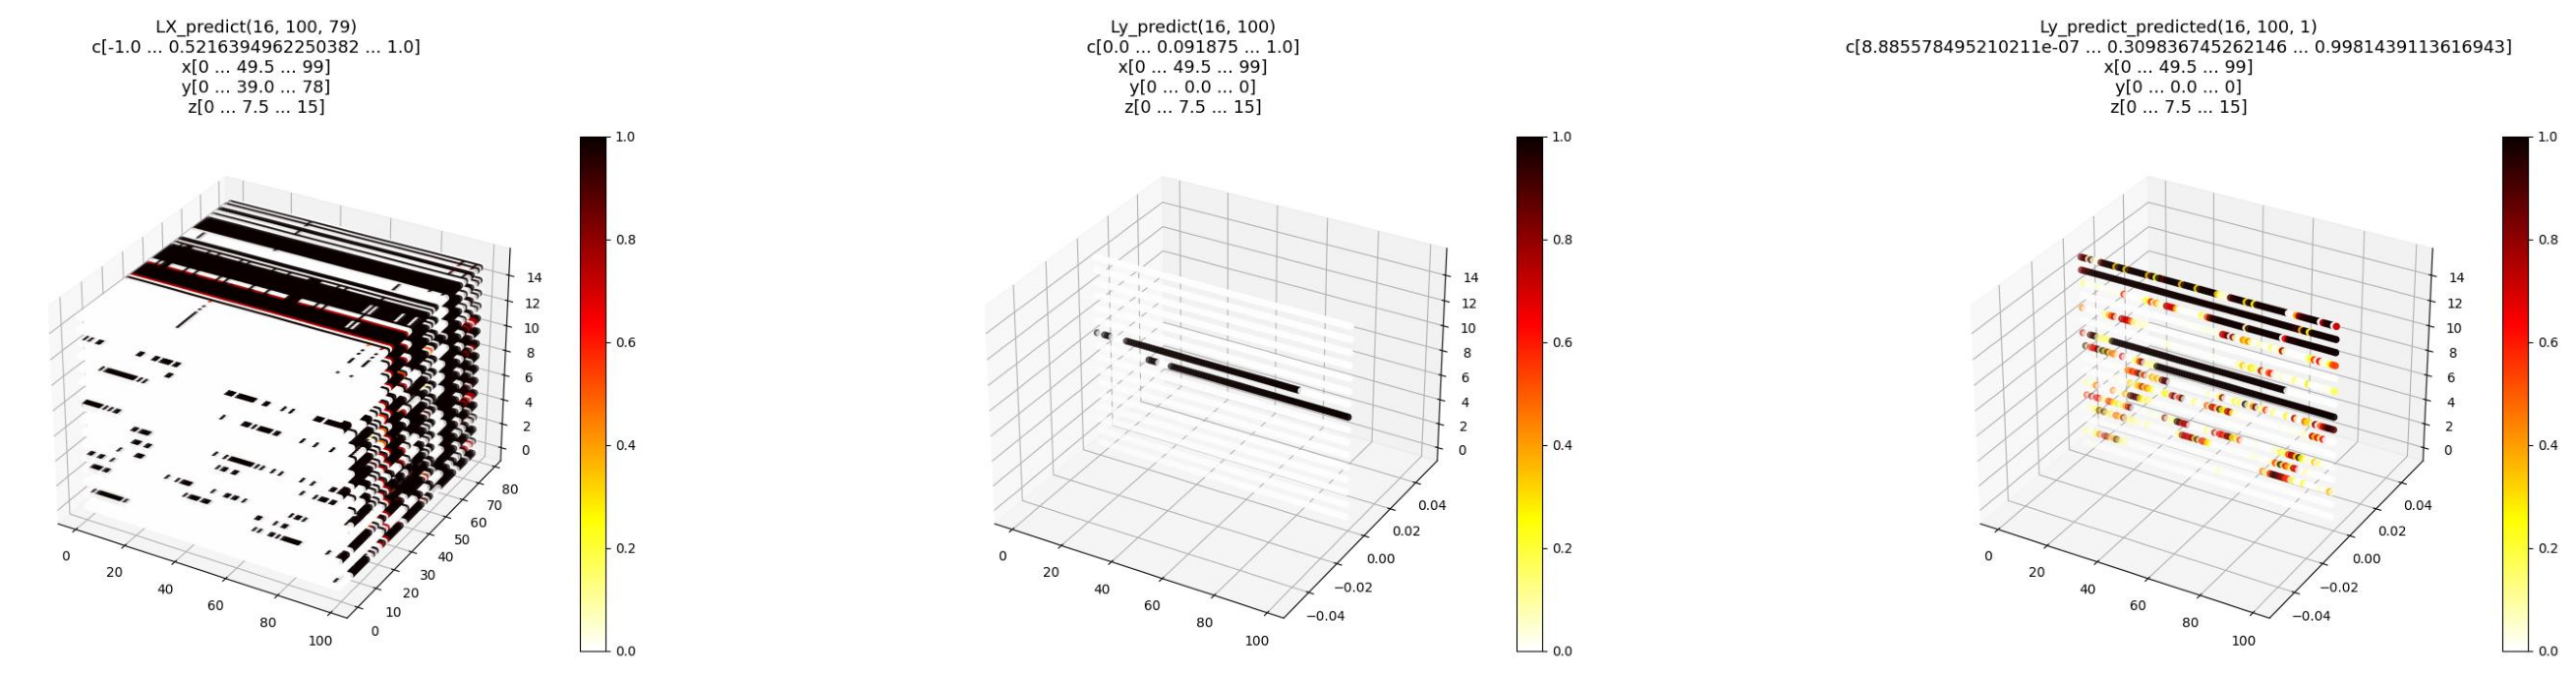

In [15]:
infer('model6', 'anomaly_flow79_local_ssh_transfer_local_ftp_norm')

predicted/Ly_predict = 254/147.0


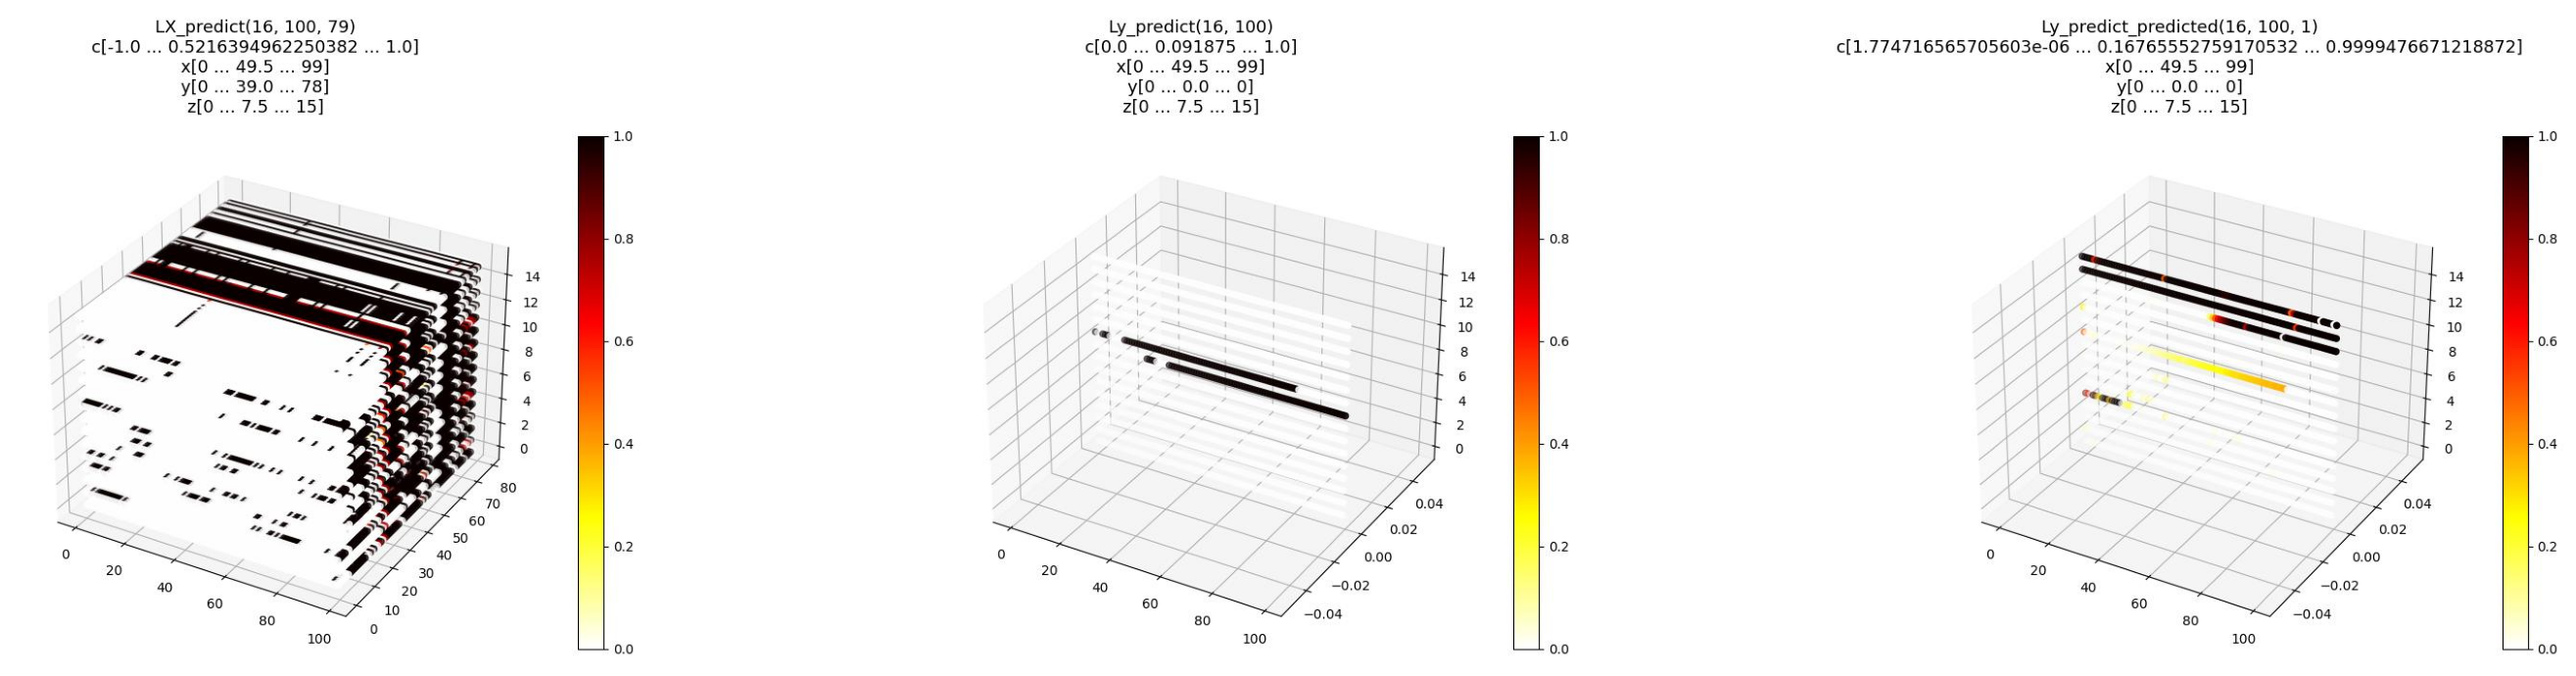

In [16]:
infer('model6', 'anomaly_flow79_local_ftp_transfer_local_ssh_norm')

predicted/Ly_predict = 626/147.0


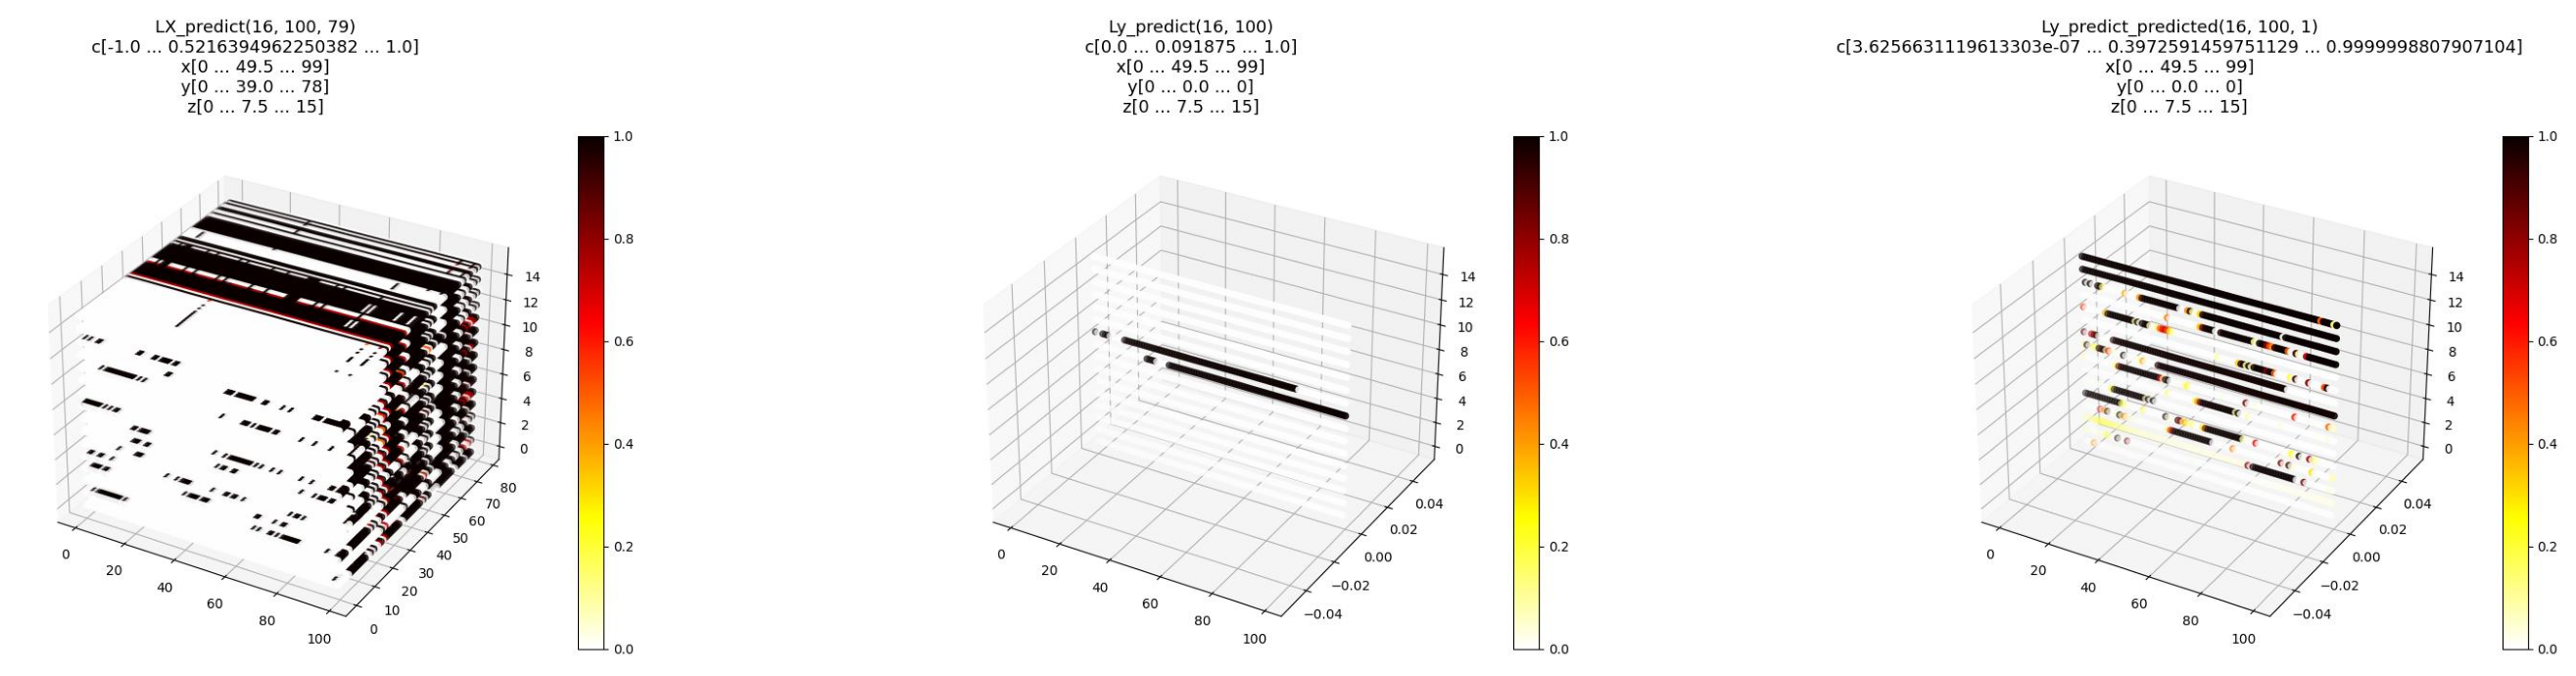

In [17]:
infer('model6', 'anomaly_flow79_local_ftp_ssh_norm')

2023-02-11 17:25:07,480[WARNING][139954536056640-MainThread] def_function.py:called_with_tracing(163) 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f470f7e9bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


predicted/Ly_predict = 175/147.0


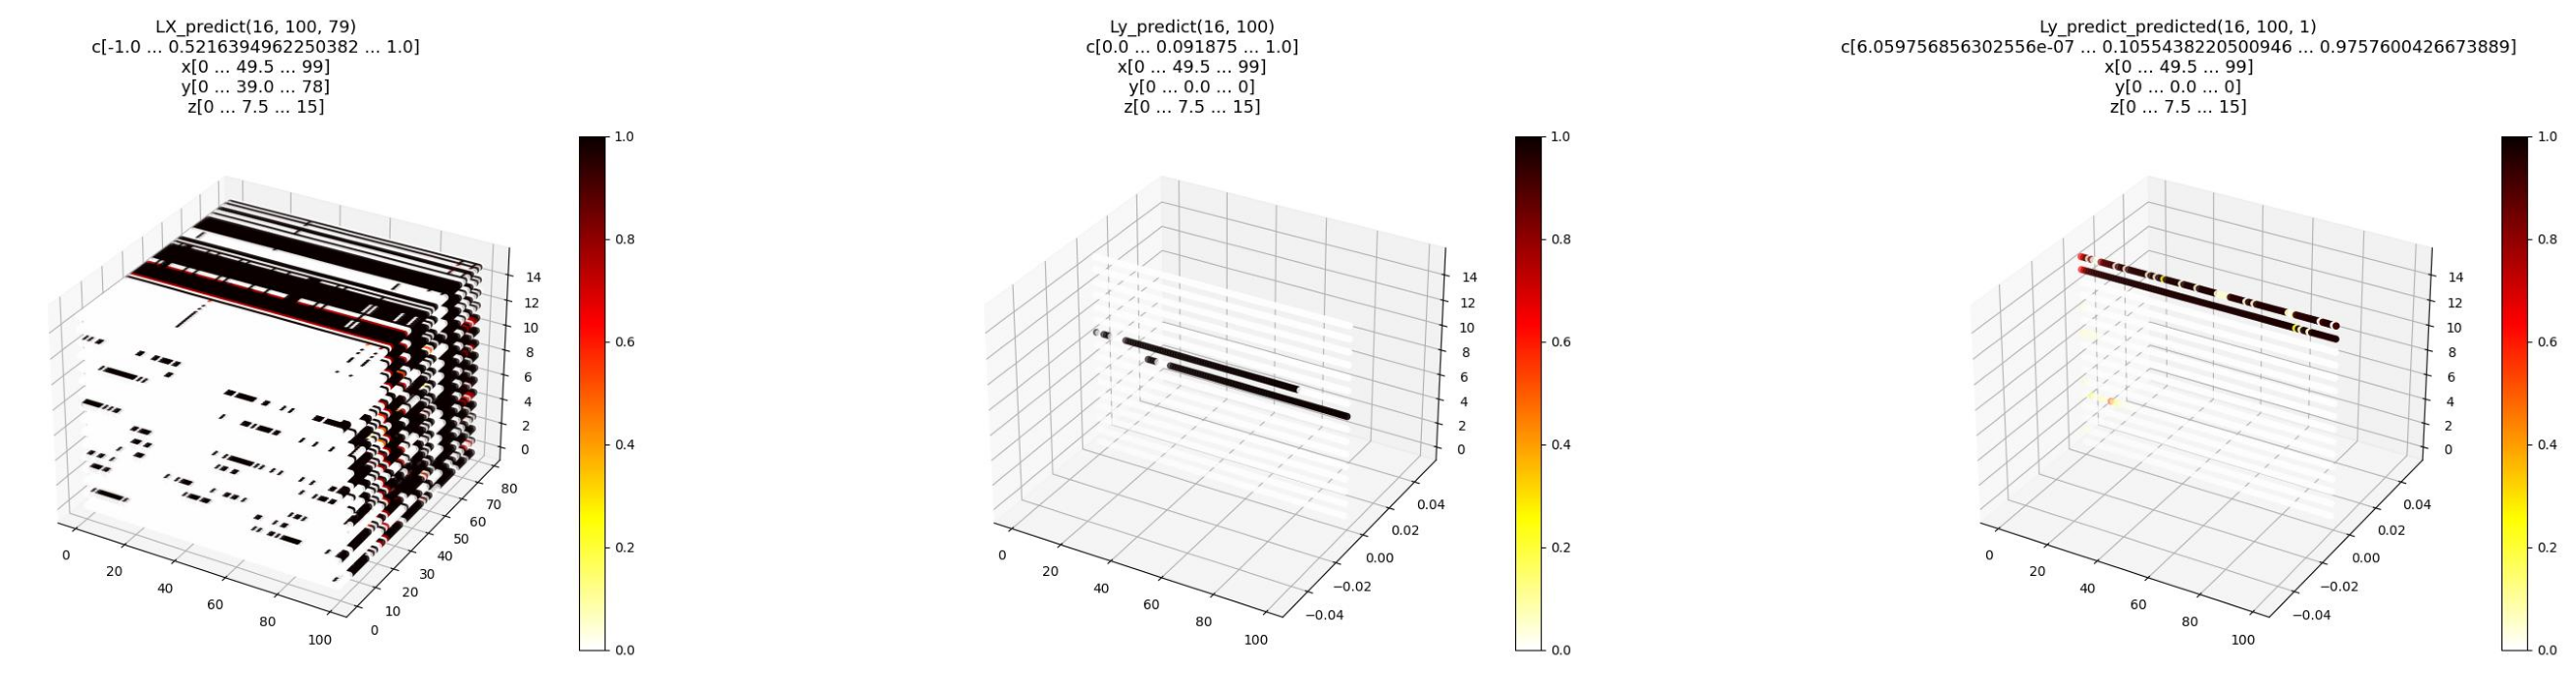

In [18]:
infer('model6', 'anomaly_flow79_local_ssh_norm')

In [19]:
#infer('model6', 'anomaly_flow79_cic_ftp_norm')